# In this file we generate the dataset for the calibration of the rHeston model with flat forward variance for the pointwise random grids approach
In the forward pass we learn the **mapping** between **rHeston parameters** and the option **implied volatility**, In this case the implied volatility surface is on an adaptive random grid 13(strikes)x11(maturities) a bit larger than the one used for the image based approach.

Below we'll sample appropriate values for the parameters of the rough Heston model, generate the random grids and price all the options.

In [1]:
#Set the directory to store dataset
import os
import pandas as pd
import numpy as np
import time
from time import perf_counter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.special import gamma
from scipy.fft import fft
import warnings
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from scipy.integrate import quad, trapz
os.chdir("C:/Users/pc/Desktop/politecnico/TESI/mio codice/rHeston/random grids")

In [2]:
def generate_rough_heston_parameters(n_samples=16000, seed=42):
    """
    Generate 16000 sets of Rough Heston parameters with Hurst exponent.
    
    Parameters:
    -----------
    n_samples : int
        Number of parameter sets to generate (default: 16000)
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    params_array : numpy.ndarray of shape (n_samples, 4)
        Array containing [H, γ, ρ, ν₀] parameters
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    # Define parameter bounds for Rough Heston model
    param_bounds = {
        'H': (0.01, 0.25),         # Hurst exponent (roughness parameter)
        'nu': (0.15, 0.65),          # Volatility of volatility
        'rho': (-0.7, -0.1),        # Correlation coefficient
        'V0': (0.005, 0.13)      # Initial volatility    
    }
    
    # Initialize array for parameters
    params_array = np.zeros((n_samples, 4), dtype=np.float64)
    
    for i in range(n_samples):
        # Generate parameters within bounds
        H = np.random.uniform(low=param_bounds['H'][0], high=param_bounds['H'][1])
        nu = np.random.uniform(low=param_bounds['nu'][0], high=param_bounds['nu'][1])
        rho = np.random.uniform(low=param_bounds['rho'][0], high=param_bounds['rho'][1])
        V0 = np.random.uniform(low=param_bounds['V0'][0], high=param_bounds['V0'][1])
        
        params_array[i, :] = [H, nu, rho, V0]

    return params_array

# Generate 16000 parameter sets
rheston_params = generate_rough_heston_parameters(16000, seed=42)

# Verify the results
print("Generated parameter sets shape:", rheston_params.shape)
print("Data type:", rheston_params.dtype)
print("\nFirst 2 parameter sets:")
print(rheston_params[:2])

Generated parameter sets shape: (16000, 4)
Data type: float64

First 2 parameter sets:
[[ 0.09988963  0.62535715 -0.26080363  0.07983231]
 [ 0.04744447  0.22799726 -0.66514983  0.11327202]]


# Let's have a look at the parameters sets and gain some more informations


=== HESTON PARAMETERS ANALYSIS (xx) ===
       H (Hurst exponent)  ν (vol of variance)  ρ (spot-vol correlation)  \
count          16000.0000           16000.0000                16000.0000   
mean               0.1299               0.3987                   -0.3999   
std                0.0691               0.1441                    0.1726   
min                0.0100               0.1500                   -0.7000   
1%                 0.0122               0.1555                   -0.6938   
5%                 0.0224               0.1756                   -0.6697   
50%                0.1299               0.3990                   -0.4000   
95%                0.2375               0.6240                   -0.1305   
99%                0.2474               0.6450                   -0.1066   
max                0.2500               0.6499                   -0.1000   

       ν₀ (initial variance)  
count             16000.0000  
mean                  0.0677  
std                   0.0362 

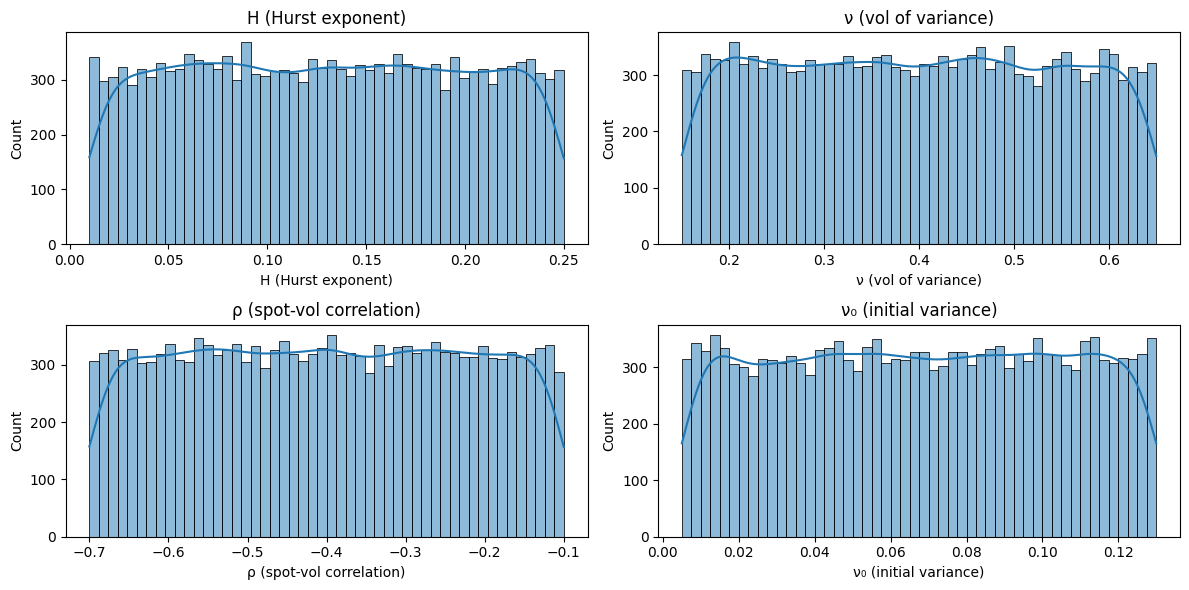

In [3]:
import seaborn as sns

#INPUT (rHESTON PARAMETERS) ANALYSIS 

# rHeston parameter names (for clarity)
#H     ∈ [0.01, 0.25]        (Hurst exponent)
#ν     ∈ [0.15, 0.65]        (initial variance)
#ρ     ∈ [-0.7, -0.1]        (spot-vol correlation)
#ν₀    ∈ [0.005, 0.13]       (vol of variance)

param_names = [
    'H (Hurst exponent)',
    'ν (vol of variance)',
    'ρ (spot-vol correlation)',
    'ν₀ (initial variance)'
]


# Create DataFrame for statistical analysis
df_xx = pd.DataFrame(rheston_params, columns=param_names)

# Descriptive statistics
print("\n=== HESTON PARAMETERS ANALYSIS (xx) ===")
print(df_xx.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).round(4))

# Validate physical bounds
print("\n=== PHYSICAL BOUNDS ===")
print(f"ν₀:    Min={df_xx.iloc[:,3].min():.4f}, Max={df_xx.iloc[:,3].max():.4f} (Expected: ~[0.005, 0.13])")
print(f"ρ:   Min={df_xx.iloc[:,2].min():.4f}, Max={df_xx.iloc[:,2].max():.4f} (Expected: ~[-0.7, -0.1])")
print(f"H: Min={df_xx.iloc[:,0].min():.4f}, Max={df_xx.iloc[:,0].max():.4f} (Expected: ~[0.01, 0.25])")

# Plot distributions
plt.figure(figsize=(12, 6))
for i, col in enumerate(df_xx.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_xx[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Step 1: Data Generation


## **Inputs:** 
###  1. $H$ Hurst exponent
###  2. $\nu$ vol of variance
###  3. $\rho$ spot-vol correlation
###  4. $\nu_{0}$ inital variance
###  5. $K$ option strike price
###  6. $T$ option maturity
    
    
## **Output:**
### Option Implied volatility 

# Generate the random grids
We will associate each parameter set $\theta -> (K_i,T_j)_{i=1,..13}^{j=1,..,11}$ a unique random grid of couples of 11 maturities, each one uniformly sampled from a specified interval, for each maturity we will generate 13 strikes which will depend on the maturity (the longer, the more distanced the strikes)

In [4]:
np.random.seed(42) # Fix seed for reproducibility

def generate_random_rHeston_grids(combined_params, S0=1.0, l=0.55, u=0.3):
    """
    Generates random grids for rHeston parameters following specified rules.
    
    Args:
        combined_params: numpy array of rHeston parameters (16000, 4) [H, γ, ρ, ν₀]
        S0: initial price (default 1.0)
        l: lower bound multiplier (default 0.55)
        u: upper bound multiplier (default 0.3)
        
    Returns:
        numpy array of shape (16000*143, 6) with columns: [H, γ, ρ, ν₀, strike, maturity]
    """
    # Define maturity intervals (11 intervals)
    maturity_intervals = [
        (0.003, 0.03), (0.03, 0.09), (0.09, 0.15), (0.15, 0.3), (0.3, 0.5),
        (0.5, 0.75), (0.75, 1.0), (1.0, 1.25), (1.25, 1.5), (1.5, 2.0), (2.0, 2.5)
    ]
    
    num_samples = combined_params.shape[0]
    num_points_per_sample = 11 * 13  # 11 maturities × 13 strikes each
    total_points = num_samples * num_points_per_sample
    
    # Initialize output array
    output = np.zeros((total_points,6))
    
    for i in range(num_samples):
        # Get current rHeston parameters
        rheston_param = combined_params[i]
        
        # Generate points for this parameter set
        points = np.zeros((num_points_per_sample,6))
        
        for j, (t_min, t_max) in enumerate(maturity_intervals):
            # Generate random maturity in this interval
            T = np.random.uniform(t_min, t_max)
            
            # Calculate strike bounds
            sqrt_T = np.sqrt(T)
            K_min = S0 * (1 - l * sqrt_T)
            K_max = S0 * (1 + u * sqrt_T)
            K_mid_low = S0 * (1 - 0.2 * sqrt_T)
            K_mid_high = S0 * (1 + 0.2 * sqrt_T)
            
            # Generate strikes according to specified distribution
            # 4 strikes in [K_min, K_mid_low]
            strikes_low = np.random.uniform(K_min, K_mid_low, 4)
            strikes_low = np.sort(strikes_low)   #sort the strikes
            
            # 7 strikes in [K_mid_low, K_mid_high]
            strikes_mid = np.random.uniform(K_mid_low, K_mid_high, 7)
            strikes_mid = np.sort(strikes_mid)   #sort the strikes

            # 2 strikes in [K_mid_high, K_max]
            strikes_high = np.random.uniform(K_mid_high, K_max, 2)
            strikes_high = np.sort(strikes_high)   #sort the strikes
            # Combine all strikes
            strikes = np.concatenate([strikes_low, strikes_mid, strikes_high])
            
            # Create points for this maturity
            start_idx = j * 13
            end_idx = (j + 1) * 13
            
            # Fill rHeston parameters
            points[start_idx:end_idx, :4] = rheston_param
            
            # Fill strikes
            points[start_idx:end_idx, 4] = strikes
            
            # Fill maturity
            points[start_idx:end_idx, 5] = T
        
        # Add to output array
        output[i*num_points_per_sample:(i+1)*num_points_per_sample] = points
    
    return output

random_grid_data = generate_random_rHeston_grids(rheston_params)
print(f"Random grid dataset shape: {random_grid_data.shape}") # Output shape will be (16000*143, 6) = (2,288,000, 6)

# Print the first two rows as example
print("First two rows of the generated dataset:")
print("Columns: [H, γ, ρ, ν₀, strike, maturity]")
for i in range(2):
    print(f"Row {i+1}: {random_grid_data[i]}")

Random grid dataset shape: (2288000, 6)
First two rows of the generated dataset:
Columns: [H, γ, ρ, ν₀, strike, maturity]
Row 1: [ 0.09988963  0.62535715 -0.26080363  0.07983231  0.9432724   0.01311258]
Row 2: [ 0.09988963  0.62535715 -0.26080363  0.07983231  0.96101277  0.01311258]


Now we have to compute the EU vanilla call prices through **SINC FFT method** to have the ground truth of the forward pass, we'll exploit the Rational approximation scheme in order to solve the fractional Riccati equation and obtain the rough Heston charcateristic function. At the end of the notebook there's the definition of the process and of the class below step by step, below we leverage a **vectorized** version which allows us to efficiently price all the EU calls in reasonable time.

In [5]:
class roughHeston_ra:
    def __init__(self, H, nu, rho, xi, S0=1.0, r=0.0, q=0.0):
        """
        Initialize the rough Heston model with rational approximation
        
        Parameters:
        -----------
        H : float
            Hurst exponent (0 < H < 0.5)
        nu : float
            vol of vol
        rho : float
            spot vol correlation
        xi : float
            Forward variance curve (scalar)
        S0 : float, optional
            spot price (default: 1.0)
        r : float, optional
            risk-free rate (default: 0.0)
        q : float, optional
            Dividend yield (default: 0.0)
        """
        self.H = H
        self.nu = nu
        self.rho = rho
        self.xi = xi
        self.S0 = S0
        self.r = r
        self.q = q
        self.alpha = H + 0.5
        
    def charfun(self, u, t, n=100):
        """
        Compute characteristic function of rough Heston model 
        
        Parameters:
        -----------
        u : array_like
            evaluation points
        t : float
            maturity
        n : int, optional
            discretization points (default: 100)
            
        Returns:
        --------
        phi : ndarray
            characteristic function
        """
        u = np.asarray(u)
        m = u.size
        
        # time grid
        ti = np.linspace(0, t, n)
        y = self.nu * ti**self.alpha
        
        # Compute Pade coefficients
        rm, rp, p1, p2, p3, q1, q2, q3 = self._dh_Pade33_coeff(u)
        
        phi = np.zeros(m, dtype=complex)
        
        for j in range(m):
            # Compute dh_Pade33 for every temporal point
            dah = self._dh_Pade33(y, rm[j], rp[j], p1[j], p2[j], p3[j], q1[j], q2[j], q3[j])
            # Integrate using trapezoidal rule
            integral = np.trapz(dah, ti)
            phi[j] = np.exp(self.xi * integral)
            
        return phi
    
    def _dh_Pade33(self, y, rm, rp, p1, p2, p3, q1, q2, q3):
        """
        Compute Pade(3,3) approximation for dh
        
        Parameters:
        -----------
        y : array_like
            input variable
        rm, rp, p1, p2, p3, q1, q2, q3 : float
            Pade coefficients
            
        Returns:
        --------
        dh : ndarray
            Pade approximation
        """
        h_pade = (p1 * y + p2 * y**2 + p3 * y**3) / (1 + q1 * y + q2 * y**2 + q3 * y**3)
        dh = 0.5 * (h_pade - rm) * (h_pade - rp)
        return dh
    
    def _dh_Pade33_coeff(self, a):
        """
        Compute Pade(3,3) approximation coefficients
        
        Parameters:
        -----------
        a : array_like
            evaluation points
            
        Returns:
        --------
        rm, rp, p1, p2, p3, q1, q2, q3 : ndarray
            Pade coefficients
        """
        a = np.asarray(a)
        
        # Compute aa, rm, rp
        aa = np.sqrt(a * (a + 1j) - self.rho**2 * a**2)
        rm = -1j * self.rho * a - aa
        rp = -1j * self.rho * a + aa
        
        # Compute coefficients b1, b2, b3
        b1 = -a * (a + 1j) / (2 * gamma(1 + self.alpha))
        b2 = (1 - a * 1j) * a**2 * self.rho / (2 * gamma(1 + 2 * self.alpha))
        b3 = (gamma(1 + 2 * self.alpha) / gamma(1 + 3 * self.alpha) * 
              (a**2 * (1j + a)**2 / (8 * gamma(1 + self.alpha)**2) + 
               (a + 1j) * a**3 * self.rho**2 / (2 * gamma(1 + 2 * self.alpha))))
        
        # Compute g0, g1, g2
        g0 = rm
        g1 = -rm / (aa * gamma(1 - self.alpha))
        g2 = (rm / aa**2 / gamma(1 - 2 * self.alpha) * 
              (1 + rm / (2 * aa) * gamma(1 - 2 * self.alpha) / gamma(1 - self.alpha)**2))
        
        # Compute denominator
        den = g0**3 + 2 * b1 * g0 * g1 - b2 * g1**2 + b1**2 * g2 + b2 * g0 * g2
        
        # Compute Pade coefficients
        p1 = b1
        p2 = (b1**2 * g0**2 + b2 * g0**3 + b1**3 * g1 + b1 * b2 * g0 * g1 - 
              b2**2 * g1**2 + b1 * b3 * g1**2 + b2**2 * g0 * g2 - b1 * b3 * g0 * g2) / den
        q1 = (b1 * g0**2 + b1**2 * g1 - b2 * g0 * g1 + b3 * g1**2 - 
              b1 * b2 * g2 - b3 * g0 * g2) / den
        q2 = (b1**2 * g0 + b2 * g0**2 - b1 * b2 * g1 - b3 * g0 * g1 + 
              b2**2 * g2 - b1 * b3 * g2) / den
        q3 = (b1**3 + 2 * b1 * b2 * g0 + b3 * g0**2 - 
              b2**2 * g1 + b1 * b3 * g1) / den
        p3 = g0 * q3
        
        return rm, rp, p1, p2, p3, q1, q2, q3
    
    def SINC_fastFT(self, K, t, pow=12, Xc=10.0, CP=1):
        """
        Compute i option prices using FFT SINC
        
        Parameters:
        -----------
        K : array_like
            Strikes
        t : float
            maturity
        pow : int, optional
            Power for N=2^pow (default: 12)
        Xc : float, optional
            truncation parameter (default: 10.0)
        CP : int, optional
            1 for call, -1 for put (default: 1)
            
        Returns:
        --------
        prices : ndarray
            option prices
        """
        K = np.asarray(K)
        if K.ndim == 0:
            K = K.reshape(1)
        
        # FFT points
        N = 2**pow
        
        # truncation range parameters
        Xm = 0.0  # Fixed as r=0
        Xl = -Xc + Xm
        Xh = Xc + Xm
        wid = Xh - Xl
        
        # Fourier frequences for put CoN
        n = np.arange(1, N//2 + 1, 2)
        wn = n / wid
        
        # Weights for odd positive frequences
        Il = 2.0 / n
        
        # Compute characteristic function in wn
        f1l = np.exp(-1j * 2 * np.pi * wn * Xm) * self.charfun(2 * np.pi * wn, t)
        f2l = np.exp(-1j * 2 * np.pi * wn * Xm) * self.charfun(2 * np.pi * wn - 1j, t)
        
        # Initialize array for even frequences
        q1l = np.zeros(N//2, dtype=complex)
        q2l = np.zeros(N//2, dtype=complex)
        
        # Assign values to odd positions
        q1l[1::2] = f1l * Il
        q2l[1::2] = f2l * Il
        
        # Weights for odd negative frequences
        Iu = -Il[::-1]
        
        # Compute characteristic function for negative frequences
        f1u = np.conj(f1l)[::-1]
        f2u = np.conj(f2l)[::-1]
        
        # Inizialize array for negative frequences
        q1u = np.zeros(N//2, dtype=complex)
        q2u = np.zeros(N//2, dtype=complex)
        
        # Assign values to odd positions
        q1u[::2] = f1u * Iu
        q2u[::2] = f2u * Iu
        
        # Combine positive and negative frequences
        q1 = 1j / (2 * np.pi) * np.concatenate([q1l, [0], q1u[:N//2-1]])
        q2 = 1j / (2 * np.pi) * np.concatenate([q2l, [0], q2u[:N//2-1]])
        
        # Compute FFT
        d1 = fft(q1) + 0.5
        d2 = fft(q2) + 0.5
        
        # Reorder FFT results
        d11 = d1[:N//2]
        d12 = d1[N//2:]
        d21 = d2[:N//2]
        d22 = d2[N//2:]
        
        dd1 = np.concatenate([d12, d11])
        dd2 = np.concatenate([d22, d21])
        
        # Create strikes grid
        m = np.arange(-N//2, N//2)
        km = m * wid / N + (self.r - self.q) * t + Xm
        Km = self.S0 * np.exp(km)
        
        # Compute digital options prices
        conP = np.exp(-self.r * t) * np.real(Km * dd1)
        aonP = np.exp(-self.q * t) * np.real(self.S0 * dd2)
        
        # Compute put prices
        put_prices = conP - aonP
        
        # Interpolate desired strikes on the grid
        if len(Km) > 1:
            interp_fn = interp1d(Km, put_prices, kind='linear', bounds_error=False, fill_value='extrapolate')
            put_interp = interp_fn(K)
        else:
            put_interp = put_prices * np.ones_like(K)
        
        # Apply put-call parity
        if CP == 1:  # Call
            prices = put_interp + self.S0 * np.exp(-self.q * t) - K * np.exp(-self.r * t)
        else:  # Put
            prices = put_interp
            
        return prices
    
    def implied_volatility(self, K, t, market_price, CP=1):
        """
        Compute implied volatility using Brent method
        
        Parameters:
        -----------
        K : array_like
            Strikes
        t : float
            maturity
        market_price : array_like
            market prices
        pow : int, optional
            Power for N=2^pow (default: 12)
        Xc : float, optional
            truncament parameter (default: 10.0)
        CP : int, optional
            1 for call, -1 for put (default: 1)
            
        Returns:
        --------
        iv : ndarray
            implied volatility
        """
        K = np.asarray(K)
        market_price = np.asarray(market_price)
        
        if K.shape != market_price.shape:
            raise ValueError("K and market_price must have the same dimension")
        
        iv = np.zeros_like(K)
        
        for i in range(len(K)):
            def price_diff(sigma):
                # Compute price difference as function of sigma
                bs_price = self._black_scholes_price(K[i], t, sigma, CP)
                return bs_price - market_price[i]
            
            try:
                # Brent's method to find implied volatility
                iv[i] = brentq(price_diff, 1e-6, 2.0, maxiter=4000, xtol=1e-8)
            except ValueError:
                # If there's no convergence, output NaN
                iv[i] = np.nan
                warnings.warn(f"Can't find implied volatility for K={K[i]}")
        
        return iv
    
    def _black_scholes_price(self, K, t, sigma, CP):
        """
        Compute Black-Scholes price
        
        Parameters:
        -----------
        K : float
            Strike
        t : float
            maturity
        sigma : float
            Volatility
        CP : int
            1 for call, -1 for put
            
        Returns:
        --------
        price : float
            Black-Scholes price
        """
        if t <= 0:
            if CP == 1:
                return max(self.S0 - K, 0)
            else:
                return max(K - self.S0, 0)
        
        d1 = (np.log(self.S0 / K) + (self.r - self.q + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        
        if CP == 1:  # Call
            price = (self.S0 * np.exp(-self.q * t) * norm.cdf(d1) - 
                    K * np.exp(-self.r * t) * norm.cdf(d2))
        else:  # Put
            price = (K * np.exp(-self.r * t) * norm.cdf(-d2) - 
                    self.S0 * np.exp(-self.q * t) * norm.cdf(-d1))
        
        return price
    
    def price_options(self, K, t, pow=12, Xc=10.0, CP=1):
        """
        Compute option prices and implied volatilities
        
        Parameters:
        -----------
        K : array_like
            Strikes
        t : float
            maturity
        pow : int, optional
            power for N=2^pow (default: 12)
        Xc : float, optional
            truncament parameter (default: 10.0)
        CP : int, optional
            1 for call, -1 for put (default: 1)
            
        Returns:
        --------
        prices : ndarray
            option prices
        iv : ndarray
            implied volatilities
        """
        prices = self.SINC_fastFT(K, t, pow, Xc, CP)
        iv = self.implied_volatility(K, t, prices, CP)
        
        return prices, iv

Now we compute the implied volatilities for all the options, thanks to the vectorization we're able to process all the 11 strikes for a given maturity, making this procedure 11 times faster with respect to truly pointwise approaches

In [6]:
from tqdm import tqdm  # For progress bar

def calculate_all_implied_vols(random_grid_data, S0=1.0, r=0.0,
                               base_Xc=2.65, Xc_step=2.3, pow=12):
    """
    Calculate implied volatilities for all option points in the random grid dataset,
    using base_Xc and Xc_step logic for each maturity.
    
    Args:
        random_grid_data: numpy array of shape (N*143, 6) with columns:
                         [H, γ, ρ, ν₀, strike, maturity]
        S0: initial spot price (default 1.0)
        r: risk-free rate (default 0.0)
        base_Xc: starting Xc for shortest maturity
        Xc_step: increment per maturity step
        pow: FFT grid power (default 12)
        cp: call (+1) or put (-1)
        
    Returns:
        Tuple of (implied_vols_array, valid_indices) where:
        - implied_vols_array: array of shape (N*143,) with IVs (NaN where calculation failed)
        - valid_indices: indices of points where IV calculation succeeded
    """
    num_samples = len(random_grid_data) // 143
    implied_vols = np.full(len(random_grid_data), np.nan)

    # Process each parameter set (each 143 options)
    for i in tqdm(range(num_samples), desc="Processing parameter sets"):
        # Get current parameter set and all its options
        start_idx = i * 143
        end_idx = (i + 1) * 143
        current_batch = random_grid_data[start_idx:end_idx]

        # Extract parameters (same for all 143 options)
        params = current_batch[0, :4]
        he_vec = roughHeston_ra(params[0], params[1], params[2], params[3])

        # Group options by maturity for efficient SINC FFT pricing
        unique_maturities = np.unique(current_batch[:, 5])

        for m_idx, T in enumerate(unique_maturities):
            maturity_mask = current_batch[:, 5] == T
            strikes = current_batch[maturity_mask, 4]

            # Compute Xc for this maturity
            Xc = base_Xc + m_idx * Xc_step

            try:
                # Pricing + implied vols for this maturity
                _, ivs = he_vec.price_options(strikes, T, pow, Xc)

                # Store results at the correct positions
                implied_vols[start_idx:end_idx][maturity_mask] = ivs
            except Exception as e:
                print(f"\nError processing set {i+1}, maturity {T:.4f}: {str(e)}")
                continue

    # Identify valid results (non-NaN)
    valid_indices = np.where(~np.isnan(implied_vols))[0]

    print(f"\nCalculation completed. Success rate: {len(valid_indices)/len(implied_vols):.2%}")
    return implied_vols, valid_indices

implied_vols, valid_idx = calculate_all_implied_vols(random_grid_data)

Processing parameter sets: 100%|██████████| 16000/16000 [8:09:05<00:00,  1.83s/it]  


Calculation completed. Success rate: 100.00%


In [7]:
# QUICK ANALYISIS OF IMPLIED VOLATILITIES COMPUTATION
failed_mask = np.isnan(implied_vols)
num_failed = failed_mask.sum()

if num_failed > 0:
    failed_points = random_grid_data[failed_mask]
    
    # Get unique parameter sets with at least one failure
    failed_params = np.unique(failed_points[:, :4], axis=0)
    num_failed_paramsets = len(failed_params)
    
    print("\nDiagnostic Summary:")
    print(f"Total failed calculations: {num_failed}")
    print(f"Unique parameter sets with failures: {num_failed_paramsets}")
else:
    print("\nAll calculations succeeded!")


All calculations succeeded!


In [8]:
# NEED TO HANDLE FAILURES IN IMPLIED VOLATILITY COMPUTATION, ENSURE DATA QUALITY
# Cut out parameters sets with failures.

def keep_only_perfect_blocks(random_grid_data, implied_vols, points_per_sample=143):
    """
    Strict cleaning that only keeps parameter sets with ALL 143 implied volatilities valid.
    
    Args:
        random_grid_data: (N*143, 6) array of [params, strike, maturity]
        implied_vols: (N*143,) array of implied volatilities
        points_per_sample: Points per parameter set (default 143)
        
    Returns:
        clean_data: (M*143, 6) array with complete blocks only
        clean_ivs: (M*143,) array without any NaNs
        n_dropped: Number of full parameter sets dropped
    """
    n_samples = len(random_grid_data) // points_per_sample
    clean_data = []
    clean_ivs = []
    n_dropped = 0
    
    for i in range(n_samples):
        block_start = i * points_per_sample
        block_end = (i+1) * points_per_sample
        block_ivs = implied_vols[block_start:block_end]
        
        # Keep only if ALL IVs are valid
        if not np.isnan(block_ivs).any():
            clean_data.append(random_grid_data[block_start:block_end])
            clean_ivs.append(block_ivs)
        else:
            n_dropped += 1
    
    # Combine results if we found valid blocks
    if clean_data:
        final_data = np.vstack(clean_data)
        final_ivs = np.concatenate(clean_ivs)
    else:
        final_data = np.empty((0, 6))
        final_ivs = np.empty((0,))
    
    print("\nStrict cleaning results:")
    print(f"Complete blocks kept: {len(clean_data)}/{n_samples}")
    print(f"Blocks dropped: {n_dropped}")
    print(f"Final dataset size: {len(final_ivs)} options ({final_data.shape[0]//points_per_sample} parameter sets)")
    
    return final_data, final_ivs, n_dropped

# Usage example:
clean_data, clean_ivs, n_dropped = keep_only_perfect_blocks(random_grid_data, implied_vols)


Strict cleaning results:
Complete blocks kept: 16000/16000
Blocks dropped: 0
Final dataset size: 2288000 options (16000 parameter sets)


=== Dataset Integrity Checks ===
NaN in clean_data: False
NaN in clean_ivs: False
IV range: [0.0260, 0.5895]

=== Parameter Set Validation ===
Found 16000 unique parameter sets

=== Option Structure Validation ===
Maturities per set: 11 (expected: 11)
Options per maturity: 13 (expected: 13)

=== First Parameter Set Sample ===
Parameters: [ 0.09988963  0.62535715 -0.26080363  0.07983231]
First 5 options:
K=0.9433 | T=0.0131 | IV=0.3490
K=0.9610 | T=0.0131 | IV=0.3163
K=0.9664 | T=0.0131 | IV=0.3063
K=0.9751 | T=0.0131 | IV=0.2902
K=0.9780 | T=0.0131 | IV=0.2849
IV Statistics:
- Total points: 2288000
- Valid IV [0-1]: 2288000 (100.00%)
- Negative IV: 0 (0.00%)
- IV > 1: 0 (0.00%)


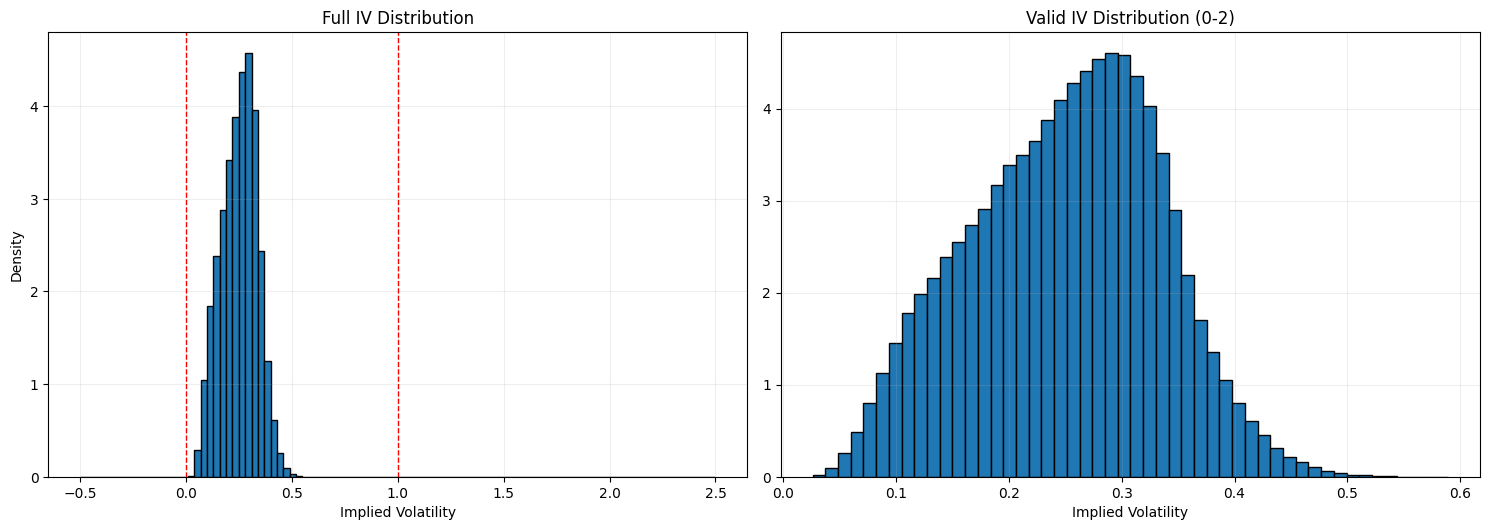

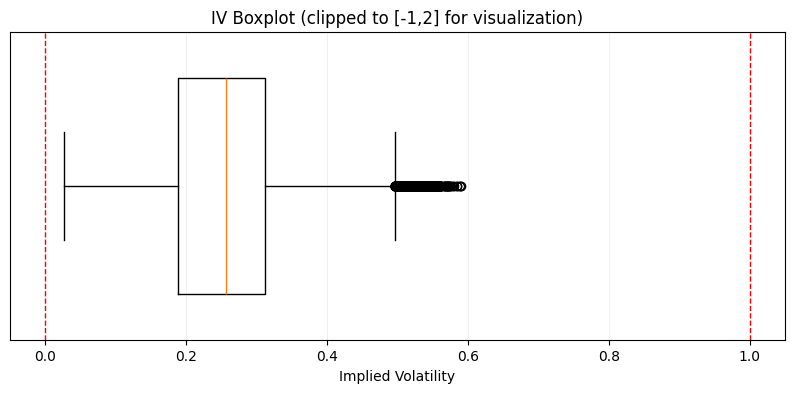

In [9]:
# HAVE MORE INSIGHTS ON THE DATA AND THE DISTRIBUTION OF IMPLIED VOLATILITIES
#================================================================================

def verify_clean_dataset(clean_data, clean_ivs, points_per_sample=143):
    """
    Performs comprehensive validation on cleaned dataset:
    1. Checks for remaining NaN values
    2. Validates implied volatility range (0-2)
    3. Verifies parameter set ordering consistency
    4. Checks maturity/strike structure
    
    Args:
        clean_data: (N*143, 6) array of [params, strike, maturity]
        clean_ivs: (N*143,) array of implied volatilities
        points_per_sample: Points per parameter set (default 143)
    """
    # --- Basic Integrity Checks ---
    print("=== Dataset Integrity Checks ===")
    print(f"NaN in clean_data: {np.isnan(clean_data).any()}")
    print(f"NaN in clean_ivs: {np.isnan(clean_ivs).any()}")
    print(f"IV range: [{clean_ivs.min():.4f}, {clean_ivs.max():.4f}]")
    
    # --- Parameter Set Consistency ---
    print("\n=== Parameter Set Validation ===")
    sample_params = clean_data[::points_per_sample, :4]  # Get first row of each block
    unique_params = np.unique(sample_params, axis=0)
    print(f"Found {len(unique_params)} unique parameter sets")
    
    # --- Strike/Maturity Structure Verification ---
    print("\n=== Option Structure Validation ===")
    first_block = clean_data[:points_per_sample]
    maturities, counts = np.unique(first_block[:,5], return_counts=True)
    print(f"Maturities per set: {len(maturities)} (expected: 11)")
    print(f"Options per maturity: {counts[0]} (expected: 13)")
    
    # --- Sample Data Inspection ---
    print("\n=== First Parameter Set Sample ===")
    print("Parameters:", clean_data[0,:4])
    print("First 5 options:")
    for i in range(5):
        print(f"K={clean_data[i,4]:.4f} | T={clean_data[i,5]:.4f} | IV={clean_ivs[i]:.4f}")

def analyze_iv_distribution(clean_ivs):
    """
    Comprehensive analysis of implied volatility distribution:
    - Statistical summary
    - Visualization of valid/invalid ranges
    - Outlier detection
    
    Args:
        clean_ivs: Array of implied volatilities
    """
    # --- Statistical Analysis ---
    stats = {
        'total': len(clean_ivs),
        'valid': np.sum((clean_ivs >= 0) & (clean_ivs <= 2)),
        'negative': np.sum(clean_ivs < 0),
        'excessive': np.sum(clean_ivs > 2)
    }
    
    print(f"IV Statistics:\n"
          f"- Total points: {stats['total']}\n"
          f"- Valid IV [0-1]: {stats['valid']} ({stats['valid']/stats['total']:.2%})\n"
          f"- Negative IV: {stats['negative']} ({stats['negative']/stats['total']:.2%})\n"
          f"- IV > 1: {stats['excessive']} ({stats['excessive']/stats['total']:.2%})")

    # --- Visualization ---
    plt.figure(figsize=(15,10))
    
    # Main distribution plot
    plt.subplot(2,2,1)
    plt.hist(clean_ivs, bins=100, range=(-0.5,2.5), density=True, edgecolor='k')
    plt.axvline(0, c='r', ls='--', lw=1)
    plt.axvline(1, c='r', ls='--', lw=1)
    plt.title('Full IV Distribution')
    plt.xlabel('Implied Volatility')
    plt.ylabel('Density')
    plt.grid(alpha=0.2)

    # Valid range zoom
    plt.subplot(2,2,2)
    valid_ivs = clean_ivs[(clean_ivs >=0) & (clean_ivs <=2)]
    plt.hist(valid_ivs, bins=50, density=True, edgecolor='k')
    plt.title('Valid IV Distribution (0-2)')
    plt.xlabel('Implied Volatility')
    plt.grid(alpha=0.2)

    # Negative IVs (if any)
    if stats['negative'] > 0:
        plt.subplot(2,2,3)
        plt.hist(clean_ivs[clean_ivs<0], bins=max(5, stats['negative']//10), edgecolor='k')
        plt.title('Negative IV Distribution')
        plt.xlabel('Implied Volatility')
        plt.grid(alpha=0.2)

    # Excessive IVs (if any)
    if stats['excessive'] > 0:
        plt.subplot(2,2,4)
        plt.hist(clean_ivs[clean_ivs>1], bins=max(5, stats['excessive']//10), edgecolor='k')
        plt.title('Excessive IV Distribution (>2)')
        plt.xlabel('Implied Volatility')
        plt.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

    # --- Outlier Analysis ---
    plt.figure(figsize=(10,4))
    boxplot_data = clean_ivs[(clean_ivs >= -1) & (clean_ivs <= 2)]
    plt.boxplot(boxplot_data, vert=False, widths=0.7)
    plt.axvline(0, c='r', ls='--', lw=1)
    plt.axvline(1, c='r', ls='--', lw=1)
    plt.title('IV Boxplot (clipped to [-1,2] for visualization)')
    plt.xlabel('Implied Volatility')
    plt.yticks([])
    plt.grid(alpha=0.2)
    plt.show()

# Example usage
verify_clean_dataset(clean_data, clean_ivs)
analyze_iv_distribution(clean_ivs)

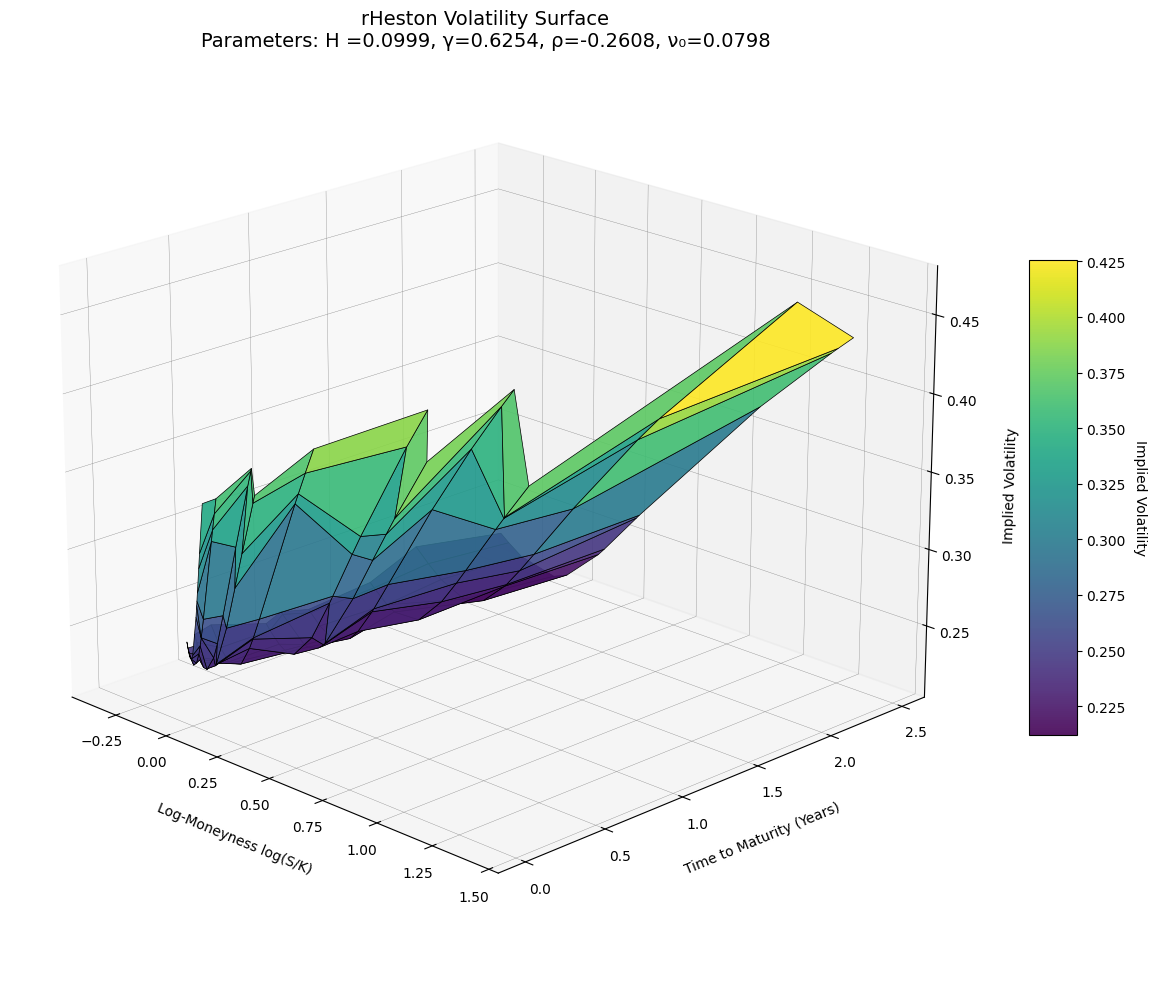

In [10]:
# PLOT ONE IMPLIED VOLATILITY SURFACE
from mpl_toolkits.mplot3d import Axes3D


def plot_rHeston_vol_surface(data, ivs, S0=1.0, param_set_idx=0, points_per_set=143, 
                           use_log_moneyness=True, show_implied_vols=True):
    """
    Plots a 3D volatility surface for a specific rHeston parameter set.
    
    Args:
        data: Full dataset array (N*143,6) with columns [H, γ, ρ, ν₀, strike,maturity]
        ivs: Implied volatilities array (N*143,)
        param_set_idx: Index of parameter set to visualize (default: 0)
        points_per_set: Number of options per parameter set (default: 143)
        use_log_moneyness: Whether to plot log(K/S0) instead of strikes (default: True)
        show_implied_vols: Whether to show IV values on hover (default: True)
    """
    # Extract the specific parameter set's options
    start_idx = param_set_idx * points_per_set
    end_idx = (param_set_idx + 1) * points_per_set
    param_set = data[start_idx:end_idx]
    param_ivs = ivs[start_idx:end_idx]
    
    # Get parameters for title
    params = param_set[0, :4]
    
    # Prepare grid structure (11 maturities × 13 strikes)
    strikes = param_set[:, 4].reshape(11, 13)
    maturities = param_set[:, 5].reshape(11, 13)
    iv_matrix = param_ivs.reshape(11, 13)
    
    # Calculate log-moneyness if requested
    if use_log_moneyness:
        x_axis = np.log(S0/strikes)  # log(S0/K)
        x_label = "Log-Moneyness log(S/K)"
    else:
        x_axis = strikes
        x_label = "Strike Price K"
    
    # Create 3D plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Surface plot
    surf = ax.plot_surface(x_axis, maturities, iv_matrix, 
                          cmap='viridis', edgecolor='k', alpha=0.9,
                          linewidth=0.5, antialiased=True)
    
    # Add colorbar
    cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
    cbar.set_label('Implied Volatility', rotation=270, labelpad=15)
    
    # Customize view angle
    ax.view_init(elev=20, azim=-45)
    
    # Labels and title
    ax.set_xlabel(x_label, labelpad=12)
    ax.set_ylabel('Time to Maturity (Years)', labelpad=12)
    ax.set_zlabel('Implied Volatility', labelpad=12)
    
    title = (f"rHeston Volatility Surface\n"
             f"Parameters: H ={params[0]:.4f}, γ={params[1]:.4f}, ρ={params[2]:.4f}, ν₀={params[3]:.4f}")
    plt.title(title, y=1.05, fontsize=14)
    
    # Add grid lines
    ax.xaxis._axinfo["grid"].update({"linewidth":0.25, "color":"gray"})
    ax.yaxis._axinfo["grid"].update({"linewidth":0.25, "color":"gray"})
    ax.zaxis._axinfo["grid"].update({"linewidth":0.25, "color":"gray"})
    
    # Add strike values on x-axis
    if not use_log_moneyness:
        ax.set_xticks(strikes[0, ::2])
        ax.set_xticklabels([f"{k:.2f}" for k in strikes[0, ::2]], rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plot with log-moneyness
plot_rHeston_vol_surface(random_grid_data, implied_vols, param_set_idx=0, use_log_moneyness=True)

In [11]:
# Save the entire dataset (useful)
def save_rHeston_dataset(clean_data , clean_ivs, filename="rHestonflatRandomGridsDataset.csv"):
    """
    Save the complete rHeston dataset (parameters + strikes + maturities + implied vols) to a CSV file.
    
    Args:
        random_grid_data: numpy array of shape (N, 6) with columns [H, γ, ρ, ν₀, strike, maturity]
        implied_vols: numpy array of shape (N,) with implied volatilities
        filename: output CSV filename (default: "rHestonflatRandomGridsDataset.csv")
    
    Returns:
        None (saves a CSV file)
    """
    # Convert to DataFrame for clean CSV export
    df = pd.DataFrame(
        data=np.column_stack((clean_data, clean_ivs)),
        columns=["H", "gamma", "rho", "nu_0", "strike", "maturity", "implied_vol"]
    )
    
    # Optional: Remove rows with NaN implied volatilities
    df_clean = df.dropna(subset=["implied_vol"])
    
    # Save to CSV
    df_clean.to_csv(filename, index=False)
    print(f"Dataset successfully saved to {filename}")
    print(f"Shape: {df_clean.shape}, {len(df) - len(df_clean)} rows removed due to NaN values")

# Example usage:
save_rHeston_dataset(clean_data, clean_ivs)

Dataset successfully saved to rHestonflatRandomGridsDataset.csv
Shape: (2288000, 7), 0 rows removed due to NaN values


# rHeston definition

We introduce the rough Heston (rHeston) price process introduced by [El Euch and Rosenbaum], which we define here by

$$dS_t := S_t \sqrt{V_t} dW_t$$

$$V_t := \nu_0 + \frac{\gamma}{\Gamma(H+\frac{1}{2})} \int_0^t \frac{ \sqrt{V_s}}{(t-s)^{\frac{1}{2}-H}}  dZ_s , dW_tdZ_t = \rho dt$$

Where the parameters are: $\nu_0>0$, the initial variance, $\rho \in (-\frac{1}{\sqrt{2}}, \frac{1}{\sqrt{2}}] $, the spot-vol correlation, $\gamma>0$, the vol-vol,  and $H \in (0, \frac{1}{2}]$, the Hurst exponent which controls the roughness of volatility sample paths.

In [6]:
# Esempio di utilizzo
H = 0.1
nu = 0.3
rho = -0.7
xi = 0.04  # Forward variance curve come scalare

# Inizializza il modello
model = roughHeston_ra(H, nu, rho, xi)

# Esempio: calcola prezzi per alcuni strikes
K = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
t = 1.0

prices, iv = model.price_options(K, t)

print("Strikes:", K)
print("Prezzi:", prices)
print("Volatilità implicite:", iv)

Strikes: [0.8 0.9 1.  1.1 1.2]
Prezzi: [0.21899714 0.13597519 0.06641447 0.02138382 0.00511541]
Volatilità implicite: [0.23419921 0.20025655 0.16666909 0.13922268 0.12956772]


# Check SINC FFT precision
Below we test the SINC FFT against the values of PV put options in Section 4.4 of SINC paper

In [6]:
# Esempio di utilizzo
H = 0.05
nu = 0.4
rho = -0.65
xi = 0.0256  # Forward variance curve come scalare

# Inizializza il modello
he = roughHeston_ra(H, nu, rho, xi)

# Esempio: calcola prezzi per alcuni strikes
K = np.array([0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2])
t = 1.0

# 1) timings: SINC FFT
t0 = time.perf_counter()
prices = he.SINC_fastFT(K, t, pow=13, Xc=18.9469, CP=-1)
t1 = time.perf_counter()

print("SINC FFT time:", t1 - t0)

print("Strikes:", K)
print("Prezzi:", prices)

SINC FFT time: 0.27355329999954847
Strikes: [0.6 0.7 0.8 0.9 1.  1.1 1.2]
Prezzi: [0.00321039 0.00635173 0.01198737 0.02245965 0.04535104 0.10844893
 0.20217726]


In [11]:
t = 0.01

# 1) timings: SINC FFT
t0 = time.perf_counter()
prices = he.SINC_fastFT(K, t, pow=13, Xc=2.7074, CP=-1)
t1 = time.perf_counter()

print("SINC FFT time:", t1 - t0)

print("Strikes:", K)
print("Prezzi:", prices)

SINC FFT time: 0.27825909992679954
Strikes: [0.6 0.7 0.8 0.9 1.  1.1 1.2]
Prezzi: [2.81434877e-10 8.88249716e-09 5.75273135e-07 4.27817900e-05
 5.06595951e-03 1.00000188e-01 2.00000012e-01]


# Smiles check
Below we check some smiles for some parameters combinations in our dataset.

[ 0.09988963  0.62535715 -0.26080363  0.07983231]
0.013112583208878786
SINC FFT time: 0.605405399997835



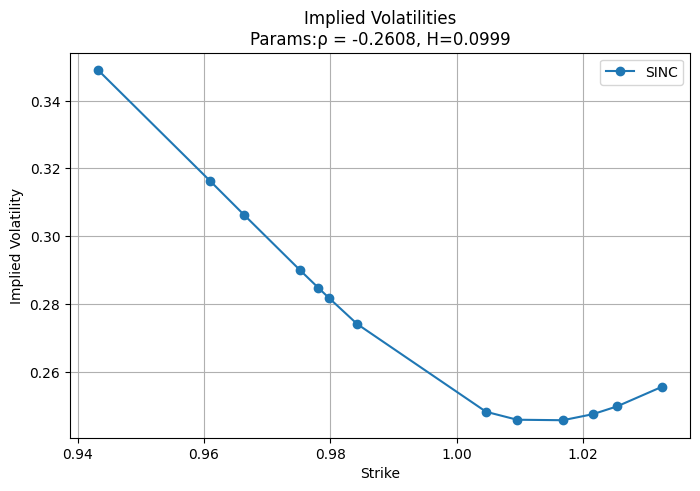

In [31]:
# Check for short maturity
params = random_grid_data[0,:4]
strikes = random_grid_data[0:13,4]
T = random_grid_data[0,5]
he  = roughHeston_ra(params[0],params[1],params[2],params[3])
print(params)
print(T)

t0 = time.perf_counter()
_, ivs_fft = he.price_options(strikes, T, pow=13, Xc=0.5, CP=1)
t1 = time.perf_counter()

print(f"SINC FFT time: {t1-t0}\n")

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_fft, 'o-', label='SINC')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[2]:.4f}, H={params[0]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
def plot_all_smiles(set_index, fixed_grid_data):
    """
    Plots all 11 smiles (implied volatilities) for a given parameter set and prints
    the parameters and total execution time.

    Parameters
    ----------
    set_index : int
        Parameter set number (1–16000).
    fixed_grid_data : np.ndarray
        Array containing parameter sets and market grid:
        - Columns 0–3: [H, γ, ρ, ν₀]
        - Column 4: strikes
        - Column 5: maturities
    """

    # Constants
    n_maturities = 11
    n_strikes = 13
    base_Xc = 2.65
    Xc_step = 2.3

    # Compute the base index for this set
    base_idx = (set_index - 1) * (n_maturities * n_strikes)

    # Extract parameters
    params = fixed_grid_data[base_idx, :4]
    H, gamma, rho, nu0 = params
    he = roughHeston_ra(H, gamma, rho, nu0)

    # Start total timing
    total_start = time.perf_counter()

    # Create plot
    fig, axes = plt.subplots(3, 4, figsize=(22, 12))
    axes = axes.flatten()

    for m in range(n_maturities):
        maturity_idx = base_idx + m * n_strikes
        strikes = fixed_grid_data[maturity_idx:maturity_idx + n_strikes, 4]
        T = fixed_grid_data[maturity_idx, 5]
        Xc = base_Xc + m * Xc_step

        # Individual timing
        t0 = time.perf_counter()
        _, ivs_fft = he.price_options(strikes, T, pow=12, Xc=Xc, CP=1)
        t1 = time.perf_counter()

        print(f"Maturity {T:.2f}, Xc={Xc:.2f}, FFT time: {t1 - t0:.4f} s")

        # Plot each smile
        ax = axes[m]
        ax.plot(strikes, ivs_fft, 'o-', label=f"T={T:.2f}")
        ax.set_title(f"T = {T:.2f}")
        ax.set_xlabel('Strike')
        ax.set_ylabel('Implied Volatility')
        ax.grid(True)
        ax.legend()

    # End total timing
    total_end = time.perf_counter()
    total_time = total_end - total_start

    # Main title with rho and H
    fig.suptitle(
        f"Implied Volatilities — ρ = {rho:.4f}, H = {H:.4f}",
        fontsize=16, y=1.02
    )
    plt.tight_layout()
    plt.show()

    # Print parameters and total time
    print("\nParameter set:")
    print(f"[H, γ, ρ, ν₀] = [{H:.6f}, {gamma:.6f}, {rho:.6f}, {nu0:.6f}]")
    print(f"Total execution time: {total_time:.4f} s")


Maturity 0.01, Xc=2.65, FFT time: 0.1887 s
Maturity 0.04, Xc=5.05, FFT time: 0.1612 s
Maturity 0.13, Xc=7.45, FFT time: 0.1967 s
Maturity 0.16, Xc=9.85, FFT time: 0.1708 s
Maturity 0.32, Xc=12.25, FFT time: 0.1848 s
Maturity 0.69, Xc=14.65, FFT time: 0.1711 s
Maturity 0.83, Xc=17.05, FFT time: 0.1860 s
Maturity 1.01, Xc=19.45, FFT time: 0.1602 s
Maturity 1.48, Xc=21.85, FFT time: 0.1767 s
Maturity 1.91, Xc=24.25, FFT time: 0.1751 s
Maturity 2.48, Xc=26.65, FFT time: 0.1697 s


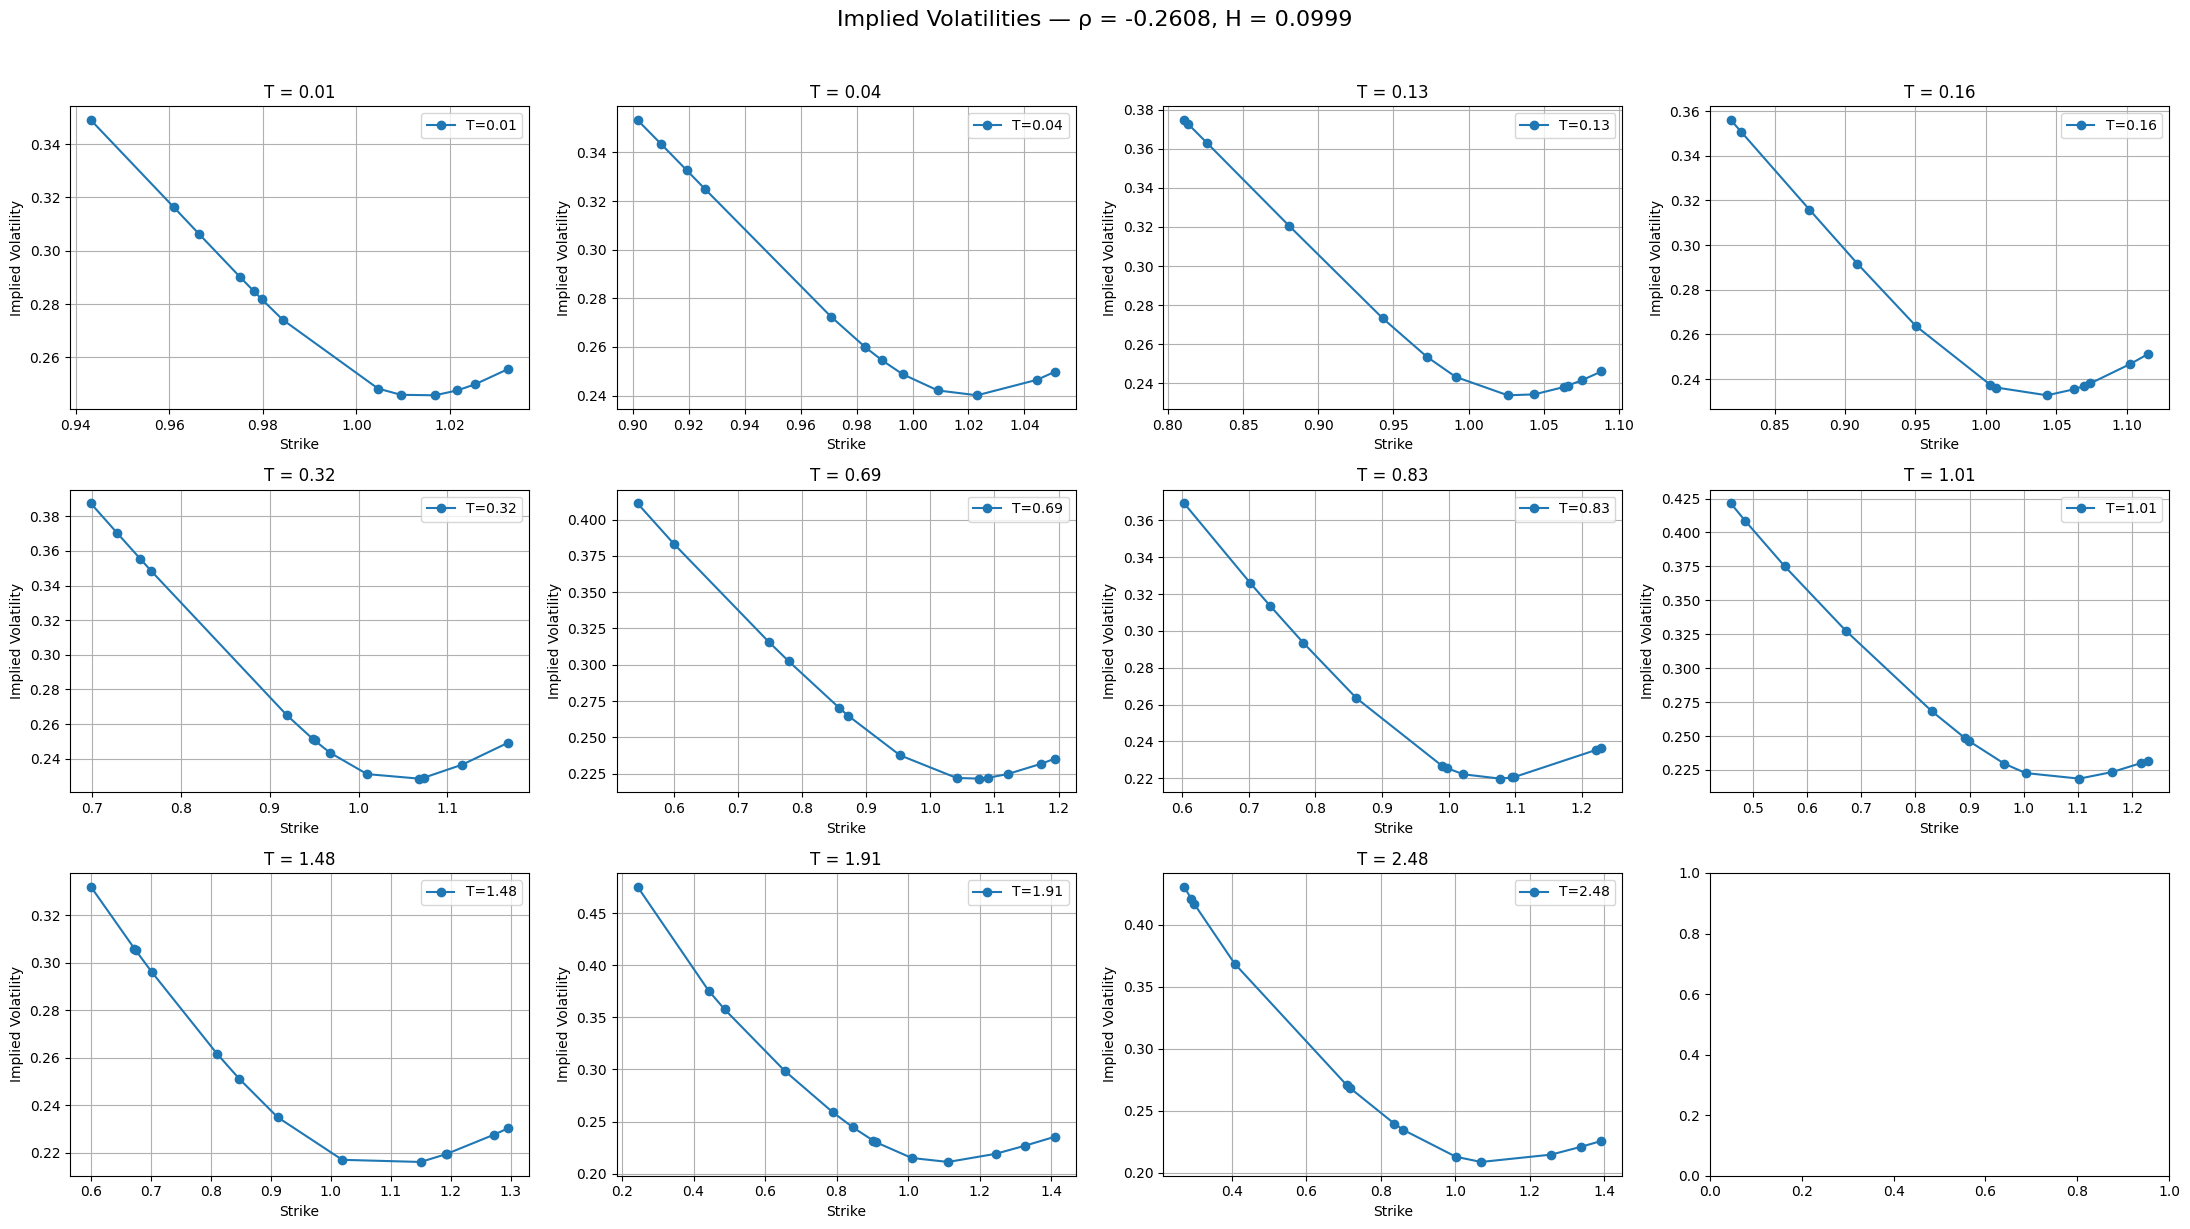


Parameter set:
[H, γ, ρ, ν₀] = [0.099890, 0.625357, -0.260804, 0.079832]
Total execution time: 2.2203 s


In [37]:
plot_all_smiles(1, random_grid_data)  # per il primo set di parametri

Maturity 0.03, Xc=2.65, FFT time: 0.3522 s
Maturity 0.08, Xc=4.95, FFT time: 0.3401 s
Maturity 0.15, Xc=7.25, FFT time: 0.2826 s
Maturity 0.21, Xc=9.55, FFT time: 0.2933 s
Maturity 0.37, Xc=11.85, FFT time: 0.3024 s
Maturity 0.51, Xc=14.15, FFT time: 0.2856 s
Maturity 0.94, Xc=16.45, FFT time: 0.3274 s
Maturity 1.08, Xc=18.75, FFT time: 0.2878 s
Maturity 1.40, Xc=21.05, FFT time: 0.2952 s
Maturity 1.70, Xc=23.35, FFT time: 0.2968 s
Maturity 2.29, Xc=25.65, FFT time: 0.3120 s


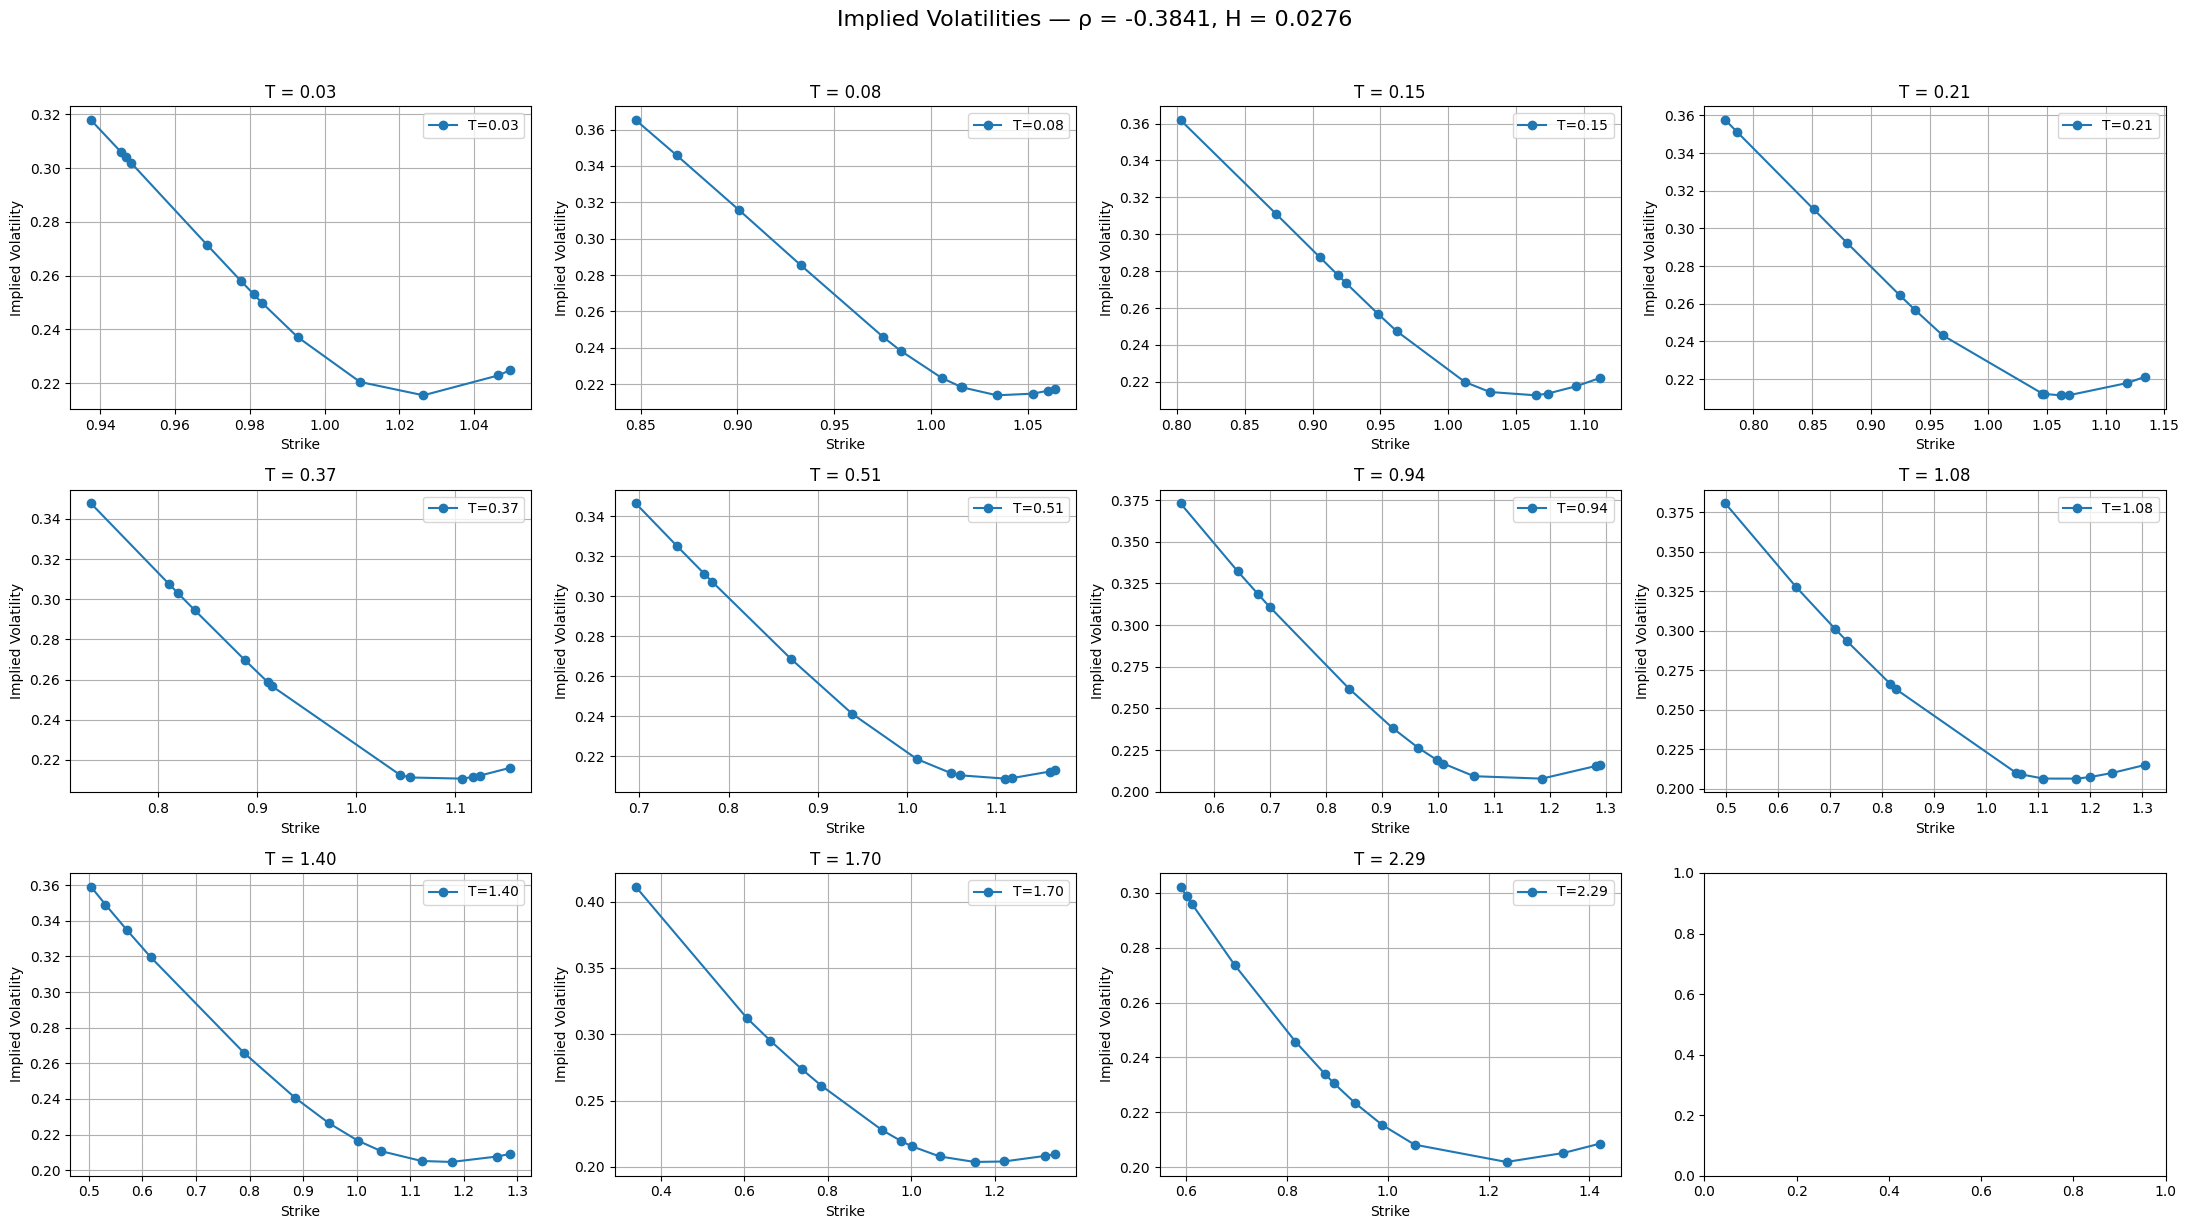


Parameter set:
[H, γ, ρ, ν₀] = [0.027576, 0.449934, -0.384101, 0.069529]
Total execution time: 3.6471 s


In [25]:
plot_all_smiles(4096, random_grid_data)  # per il secondo set di parametri

Maturity 0.01, Xc=2.65, FFT time: 0.2053 s
Maturity 0.07, Xc=4.95, FFT time: 0.2250 s
Maturity 0.11, Xc=7.25, FFT time: 0.1779 s
Maturity 0.28, Xc=9.55, FFT time: 0.1951 s
Maturity 0.44, Xc=11.85, FFT time: 0.1599 s
Maturity 0.71, Xc=14.15, FFT time: 0.1812 s
Maturity 0.83, Xc=16.45, FFT time: 0.1635 s
Maturity 1.19, Xc=18.75, FFT time: 0.1855 s
Maturity 1.27, Xc=21.05, FFT time: 0.1670 s
Maturity 1.74, Xc=23.35, FFT time: 0.1835 s
Maturity 2.33, Xc=25.65, FFT time: 0.1645 s


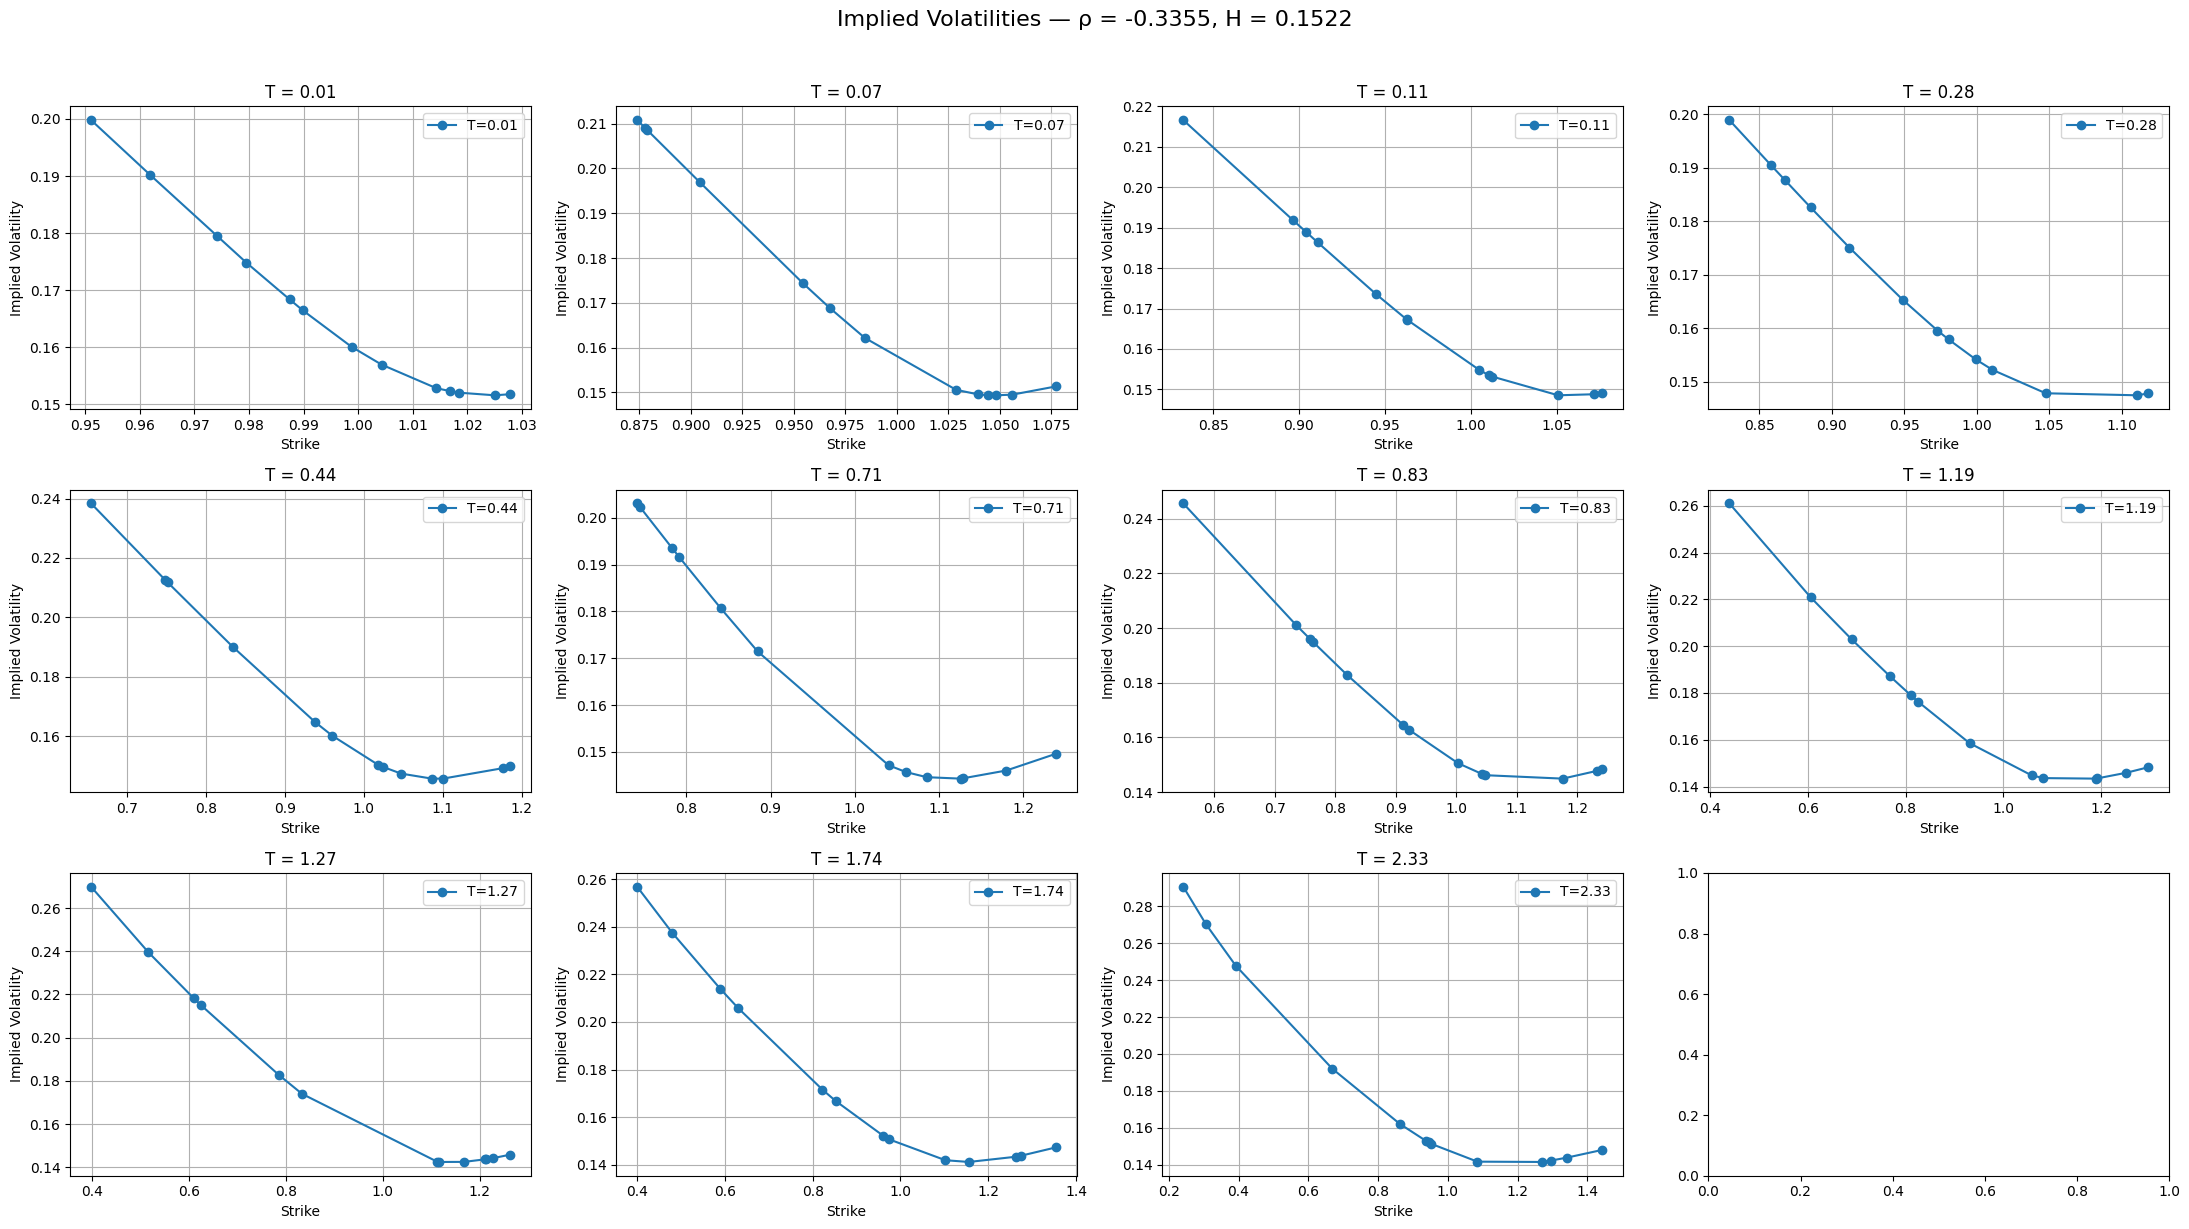


Parameter set:
[H, γ, ρ, ν₀] = [0.152179, 0.173225, -0.335473, 0.026316]
Total execution time: 2.2189 s


In [35]:
plot_all_smiles(8, random_grid_data)  # per il secondo set di parametri